## Подготовка данных

In [4]:
!pip install catboost

In [5]:
import numpy as np
import pandas as pd
import IPython
from IPython.display import display
import re
import random
import warnings
warnings.simplefilter('ignore')
import calendar


import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px


from sklearn.metrics import SCORERS
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, PolynomialFeatures
from sklearn.utils import shuffle, resample


from sklearn.dummy import DummyRegressor
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor, Pool
import xgboost as xgb
import lightgbm as lgb

1. Загружаю всё необходимое для проекта.
2. Исследую датафрейм.

In [6]:
df = pd.read_csv('/content/sample_data/autos.csv')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [8]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


**Итоги "первого взгляда":**

1. Есть пропущенные значения.
2. Дата создания и скачивания объявления, дата последнего визита пользователя, месяц регистрации и почтовый индекс скорее всего не пригодятся для исследований.
3. Большая часть признаков - категориальные. Из количественных - пройденный километраж, мощность двигателя. и скорее всего год регистрации.

In [9]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [10]:
df.describe(include=['object', 'bool'])

,DateCrawled,VehicleType,Gearbox,Model,FuelType,Brand,Repaired,DateCreated,LastSeen
count,354369,316879,334536,334664,321474,354369,283215,354369,354369
unique,271174,8,2,250,7,40,2,109,179150
top,2016-03-24 14:49:47,sedan,manual,golf,petrol,volkswagen,no,2016-04-03 00:00:00,2016-04-06 13:45:54
freq,7,91457,268251,29232,216352,77013,247161,13719,17


**Итоги "второго взгляда":**

1. Есть "странные" даты регистрации автомобилей
2. 150000 километров максимальный пробег автомобиля, возможно это ограничение сайта.
3. Странная кодитовка месяца регистрации.
4. Самая популярная машина Фольксваген Гольф.
5. Странные типы топлива, надо посмотреть.

In [11]:
total = df.isnull().sum().sort_values(ascending = False)
percent = round(df.isnull().sum().sort_values(ascending = False)/len(df)*100,2)
pd.concat([total, percent], axis=1, keys=['Total','Percent']).style.background_gradient(cmap='Greens')

,Total,Percent
Repaired,71154,20.080000
VehicleType,37490,10.580000
FuelType,32895,9.280000
Gearbox,19833,5.600000
Model,19705,5.560000
DateCrawled,0,0.000000
Price,0,0.000000
RegistrationYear,0,0.000000
Power,0,0.000000
Kilometer,0,0.000000


**Итоги "третьего взгляда":**
1. Не все отметили была ли машина в ремонте. При продаже это важно. Скорее всего, если не были, то человек просто ничего не отмечал, поэтому предположу, что нет, и тоже самое поставлю в таблице.
2. Тип автомобиля попробуем заполнить по марке и модели. Модель - по марке. Тип коробки - по году выпуска. Тип топлива - скорее всего, по модели.

Проработаю "странные" даты регистрации автомобилей. Форт Т - первый массовый автомобиль. Был выпущен в 1908 году, поэтому отсюда и буду смотреть. Всё таки они ещё продаются даже)

In [12]:
period = (df.query('RegistrationYear > 1908 and RegistrationYear < 2020')['RegistrationYear'].sort_values())
period

225468    1910
208755    1910
213796    1910
150021    1910
302641    1910
          ... 
30319     2019
165246    2019
332451    2019
62996     2019
37181     2019
Name: RegistrationYear, Length: 354198, dtype: int64

In [13]:
df_for_drop = np.round(100 - (len(period) * 100 / len(df)), 3)
print('% машин под удаление', df_for_drop)

% машин под удаление 0.048


1. % очень маленький, можно смело дропать.
2. Стоит отметить, что есть автомобили с нулевой ценой, но тут не знаю как их можно заполнить. Думаю пока оставить.

In [14]:
df = df.query('RegistrationYear > 1908 and RegistrationYear < 2020')

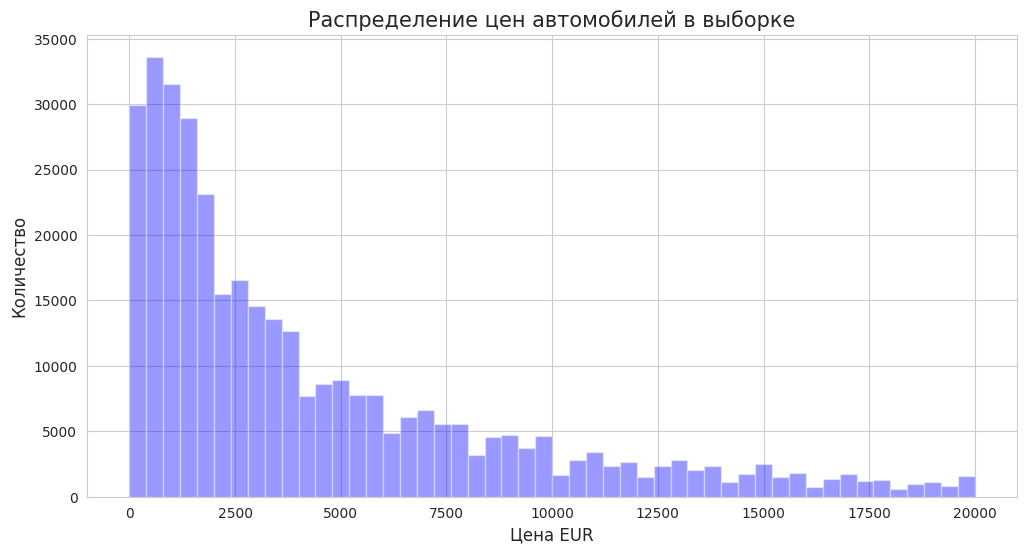

In [15]:
sns.set_style('whitegrid')

plt.figure(figsize=(12,6))
sns.distplot(df['Price'], kde=False, color='blue')

plt.xlabel('Цена EUR', size=12)
plt.ylabel('Количество', size=12)
plt.title('Распределение цен автомобилей в выборке', size=15);

Распределение цен находится в "адекватном" промежутке. Поэтому тут можно не переживать.

Приведу значения ч.м.д. к нормальному формату.

In [16]:
df['DateCreated'] = pd.to_datetime(df['DateCreated'], format='%Y-%m-%dT%H:%M:%S')
df['MonthCreated'] = df['DateCreated'].dt.weekday
df['YearCreated'] = df['DateCreated'].dt.year

In [17]:
df['MonthCreated'].value_counts()

0    63258
5    57003
1    51381
6    48821
2    47255
3    45530
4    40950
Name: MonthCreated, dtype: int64

Очень странно, что машины продаются только 7 месяцев в году. Скорее всего это баг на сайте объявлений. Что то с этим сделать в проекте врят ли возможно.

In [18]:
temp = df.groupby('MonthCreated')['Price'].median()
temp.head()

MonthCreated
0    2700.0
1    2500.0
2    2600.0
3    2650.0
4    2750.0
Name: Price, dtype: float64

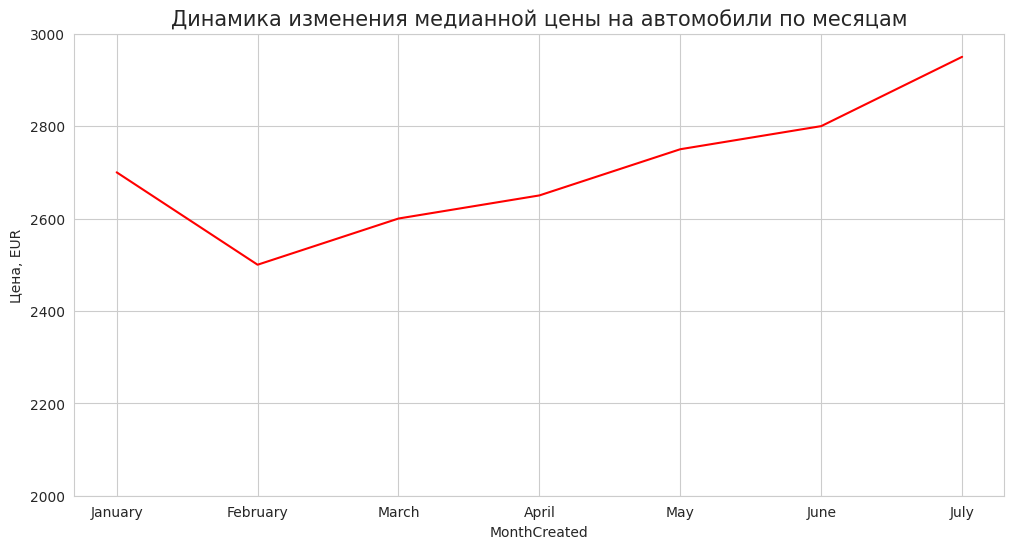

In [19]:
plt.figure(figsize=(12,6))
sns.lineplot(data=temp, color='red')
plt.ylim(2000,3000)
plt.xticks(np.arange(7), calendar.month_name[1:8])
plt.ylabel('Цена, EUR')
plt.title('Динамика изменения медианной цены на автомобили по месяцам', size=15);

Самые "дешевые" автомобили в феврале, самые "дорогие" в июле.

Теперь проверю распределение объявлений по годам.

In [20]:
temp = df.groupby('YearCreated')['Price'].agg(['median', 'count']).reset_index()
temp.head()

,YearCreated,median,count
0,2014,8999.0,1
1,2015,6000.0,25
2,2016,2700.0,354172


В 2014 году выставлена на продажу всего одна машина, в 2015 -  25 машин, в 2016 - 99% всей выборки. Сложно объяснить, возможно сайт был совсем не популярен в 2014 году. Оставлю как есть.

In [75]:
print(df.columns)

Index(['datecrawled', 'price', 'vehicletype', 'registrationyear', 'gearbox',
       'power', 'model', 'kilometer', 'registrationmonth', 'fueltype', 'brand',
       'repaired', 'datecreated', 'numberofpictures', 'postalcode', 'lastseen',
       'monthcreated', 'yearcreated', 'gearboxunsorted', 'power_norm'],
      dtype='object')


### Заполнение пропусков

**Ремонт автомобиля**

In [76]:
not_rem = df.loc[df['repaired'].isna()]['registrationyear'].value_counts()
not_rem_perc = not_rem.head(10).sum() / df.loc[df['repaired'].isna(), 'price'].count()

print(not_rem.head(10))
print()
print('Автомобили без указания ремонта, составляют {:.2%} от общего количества'.format((not_rem_perc)))

2000    7284
1999    4847
2017    4594
2005    4452
2016    4424
1998    4073
2001    3615
1997    3569
1995    3328
2002    3160
Name: registrationyear, dtype: int64

Автомобили без указания ремонта, составляют 61.06% от общего количества


Как указывал выше, все пропущенные значения здесь заполню строкой 'no'.
Все автомобили, без указания ремонта можно сказать новые. Скорее всего, тут учитывается именно ремонт после ДТП, поэтому заполню как и указал.

In [77]:
df['notrepaired'] = df['repaired'].fillna(value='no')
df['notrepaired'].head()

0     no
1    yes
2     no
3     no
4     no
Name: notrepaired, dtype: object

**Коробка передач**

In [22]:
df['Gearbox'].head()

0    manual
1    manual
2      auto
3    manual
4    manual
Name: Gearbox, dtype: object

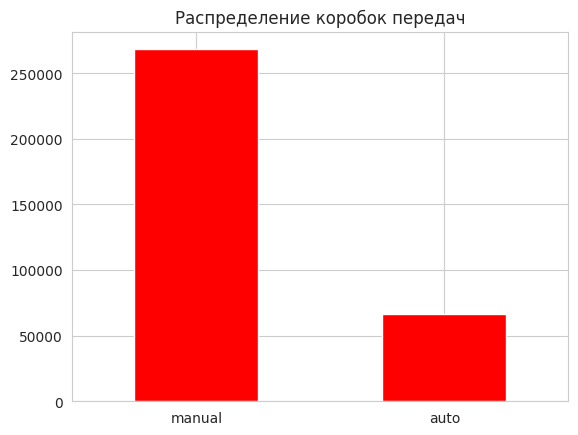

In [23]:
plt.figure()
df['Gearbox'].value_counts().plot(kind='bar', color='red')
plt.xticks(rotation=0)
plt.title('Распределение коробок передач');

Ручных коробок передач практически в 5 раз больше

In [24]:
df['GearboxUnsorted'] = df['Gearbox'].fillna(value='unsorted')
df['Gearbox'] = df['Gearbox'].fillna('manual')

Сделаю 2 столбца, один будет с неотсортированными коробками, второй с заполненными пустыми значениями на ручную коробку,посмотрю, с какми значениями будет лучше работать модель машинного обучения, хотя можно было бы заморочиться, посмотреть подробнее пропуски и прописать для конкретных моделей, но данных оказалось много, поэтому не буду тратить время, на цену вроде как сильно не влияет.

**Модель автомобиля**

In [25]:
temp = pd.DataFrame(df.groupby(['Brand'])['Model'].count()).reset_index()

temp.sort_values(by='Model', ascending=False).tail()

,Brand,Model
13,jaguar,491
17,lancia,448
28,rover,404
16,lada,210
33,sonstige_autos,0


sonstige_autos переводчик перевел как "Другие автомобили". Видимо моделей таких авто на сайте нет. Для удобства запихну их в other

In [26]:
len(df.query('Brand == "sonstige_autos"'))

3338

In [27]:
len(df.loc[df['Model']=="other"])

24403

In [28]:
df.loc[df['Brand']=='sonstige_autos', 'Model'] = df.loc[df['Brand']=='sonstige_autos', 'Model'].fillna('other')

In [29]:
len(df.loc[df['Model']=="other"])

27741

In [30]:
df['Model'].isna().sum()

16292

Пропуски, как и писал выше, заполню на основе лямбда функции самыми частыми представителями брендов.

In [31]:
mod_dict = df.groupby(['Brand'])['Model'].apply(lambda x: x.mode()[0])

df['Model'] = df['Model'].fillna(df['Brand'].map(mod_dict))

In [32]:
df['Model'].isna().sum()

0

In [33]:
df.isna().sum().sort_values()

DateCrawled              0
MonthCreated             0
LastSeen                 0
PostalCode               0
NumberOfPictures         0
DateCreated              0
Brand                    0
YearCreated              0
GearboxUnsorted          0
Kilometer                0
Model                    0
Power                    0
Gearbox                  0
RegistrationYear         0
Price                    0
RegistrationMonth        0
FuelType             32767
VehicleType          37319
Repaired             71007
dtype: int64

**Модель кузова**

In [34]:
vt_dict = dict(df.groupby(['Model'])['VehicleType'].apply(lambda x: x.mode()[0]))

df['VehicleType'] = df['VehicleType'].fillna(df['Model'].map(vt_dict))

Проделал тоже самое, на основе лямбда функции.

In [35]:
df.isna().sum().sort_values()

DateCrawled              0
MonthCreated             0
LastSeen                 0
PostalCode               0
NumberOfPictures         0
DateCreated              0
Brand                    0
YearCreated              0
GearboxUnsorted          0
Kilometer                0
Model                    0
Power                    0
Gearbox                  0
RegistrationYear         0
VehicleType              0
Price                    0
RegistrationMonth        0
FuelType             32767
Repaired             71007
dtype: int64

**Тип топлива**

In [36]:
df['FuelType'].value_counts()

petrol      216318
gasoline     98713
lpg           5310
cng            564
hybrid         233
other          203
electric        90
Name: FuelType, dtype: int64

Типы топлива адекватные, поэтому спасаемся от пропусков великой лямбда функцией.

In [37]:
fuel_dict = df.groupby(['Model'])['FuelType'].apply(lambda x: x.mode()[0])

np.unique(fuel_dict.values)

array(['gasoline', 'petrol'], dtype=object)

In [38]:
df['FuelType'].isna().sum()

32767

In [39]:
df['FuelType'] = df['FuelType'].fillna(df['Model'].map(fuel_dict))

In [40]:
df['FuelType'].isna().sum()

0

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354198 entries, 0 to 354368
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354198 non-null  object        
 1   Price              354198 non-null  int64         
 2   VehicleType        354198 non-null  object        
 3   RegistrationYear   354198 non-null  int64         
 4   Gearbox            354198 non-null  object        
 5   Power              354198 non-null  int64         
 6   Model              354198 non-null  object        
 7   Kilometer          354198 non-null  int64         
 8   RegistrationMonth  354198 non-null  int64         
 9   FuelType           354198 non-null  object        
 10  Brand              354198 non-null  object        
 11  Repaired           283191 non-null  object        
 12  DateCreated        354198 non-null  datetime64[ns]
 13  NumberOfPictures   354198 non-null  int64   

**Избавление от дубликантов**

In [42]:
df = df.drop_duplicates()

Дропнул дубликанты.

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354194 entries, 0 to 354368
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354194 non-null  object        
 1   Price              354194 non-null  int64         
 2   VehicleType        354194 non-null  object        
 3   RegistrationYear   354194 non-null  int64         
 4   Gearbox            354194 non-null  object        
 5   Power              354194 non-null  int64         
 6   Model              354194 non-null  object        
 7   Kilometer          354194 non-null  int64         
 8   RegistrationMonth  354194 non-null  int64         
 9   FuelType           354194 non-null  object        
 10  Brand              354194 non-null  object        
 11  Repaired           283187 non-null  object        
 12  DateCreated        354194 non-null  datetime64[ns]
 13  NumberOfPictures   354194 non-null  int64   

**Мощность двигателя**

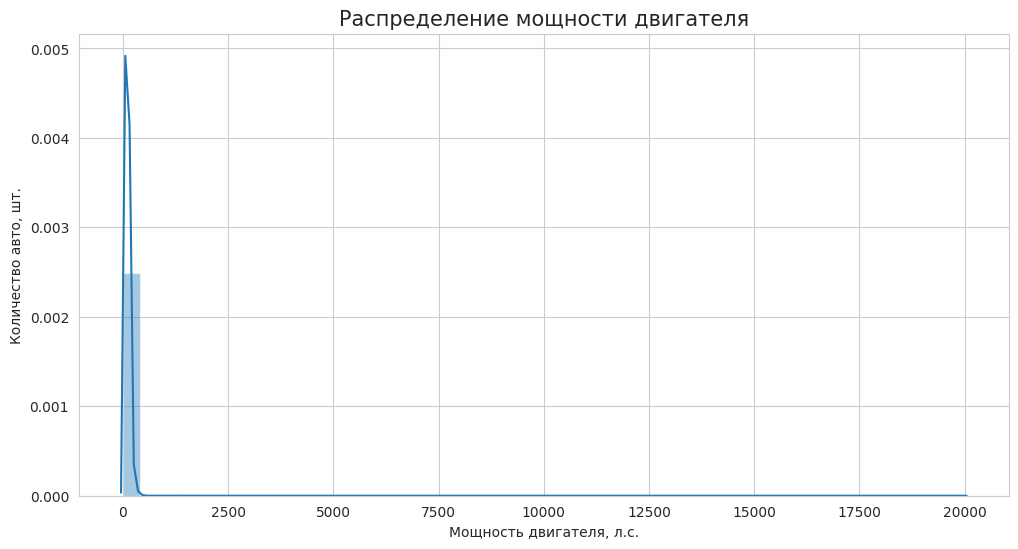

In [44]:
plt.figure(figsize=(12,6))
sns.distplot(df['Power'])
plt.xlabel('Мощность двигателя, л.с.')
plt.ylabel('Количество авто, шт.')
plt.title('Распределение мощности двигателя',size=15);

Есть нулевые значения и очень большие. Сомневаюсь, что там ядерный двигатель)

In [45]:
df.query('Power > 400')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,MonthCreated,YearCreated,GearboxUnsorted
1816,2016-03-22 20:52:00,3200,small,2004,manual,1398,corolla,5000,6,petrol,toyota,no,2016-03-22,0,22043,2016-03-22 21:43:26,1,2016,manual
2102,2016-03-21 11:55:22,0,sedan,1999,manual,1799,vectra,150000,1,petrol,opel,yes,2016-03-21,0,1723,2016-04-04 04:49:06,0,2016,unsorted
2781,2016-03-16 00:37:16,19500,suv,2004,auto,450,cayenne,125000,12,petrol,porsche,no,2016-03-16,0,38448,2016-04-01 22:47:31,2,2016,auto
3289,2016-03-10 17:46:47,16899,wagon,2003,auto,476,e_klasse,150000,9,petrol,mercedes_benz,no,2016-03-10,0,44319,2016-04-03 18:47:41,3,2016,auto
3746,2016-03-21 14:48:31,0,small,2017,manual,750,fortwo,150000,8,petrol,smart,no,2016-03-21,0,49356,2016-03-24 03:44:59,0,2016,manual
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353493,2016-04-02 20:54:21,12500,sedan,2017,manual,2000,other,60000,0,gasoline,chrysler,no,2016-04-02,0,44145,2016-04-06 21:44:39,5,2016,manual
353633,2016-03-23 23:55:21,2400,sedan,2007,manual,650,c2,150000,8,petrol,citroen,NaN,2016-03-23,0,45277,2016-03-27 01:15:17,2,2016,manual
354045,2016-03-22 20:48:48,20000,coupe,2006,auto,476,other,125000,7,petrol,mercedes_benz,no,2016-03-22,0,38118,2016-03-24 05:16:02,1,2016,auto
354260,2016-03-09 17:59:03,399,other,1994,manual,1103,3er,150000,0,petrol,bmw,NaN,2016-03-09,0,56235,2016-03-17 09:17:08,2,2016,unsorted


Видно приличное число очень больших значений. Если например, для Е-Класса, Порша Кайен ещё верю, то вектра и королла врят ли чипуются до 1400 л/с. Всё таки не Бугатти Широн) Напишу функцию, чтобы снизить на порядок эти значения, чтобы влезть в нормальный интервал. Предлагаю от 600 до 5000 поделить на 10, от 5000 и выше на 100, тогда значения будут приемлемы.

In [46]:
def norm_power(row):

    power = row['Power']

    if 600 <= power <= 5000:
        return power / 10
    if 5001 <= power <= 9999:
        return power / 100
    if power < 50:
        return np.nan
    else:
        return power

In [47]:
df['Power_norm'] = df.apply(norm_power, axis=1)

In [48]:
df['Power_norm'].isna().sum()

46040

In [49]:
df = df.drop(df.loc[df['Power']>=10000].index)

In [50]:
df['Power_norm'] = df.groupby('Model')['Power_norm'].transform(lambda x: x.fillna(value=x.median()))
print('Пропуски значений мощности', df['Power_norm'].isna().sum())
print('Нулевая мощность', len(df[df['Power_norm']==0]))

Пропуски значений мощности 2
Нулевая мощность 0


In [51]:
df = df.drop(df[df['Power_norm'].isna()].index)
df['Power_norm'] = df['Power_norm'].astype('int')
print('Пропуски значений', df['Power_norm'].isna().sum())

Пропуски значений 0


На "всякий случай" столбец не переписываю, а создам новый с более нормальными значениями мощности. Ну и соответственн избавлю его от пропусков.

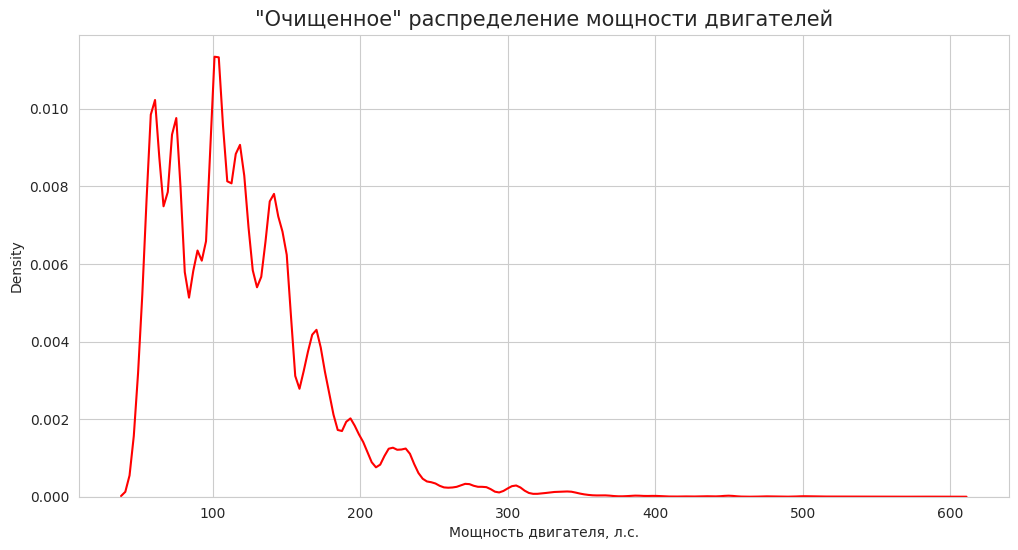

In [52]:
plt.figure(figsize=(12,6))

sns.distplot(df['Power_norm'], color='red', hist=False)

plt.xlabel('Мощность двигателя, л.с.')
plt.title('"Очищенное" распределение мощности двигателей',size=15);

In [53]:
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType              0
RegistrationYear         0
Gearbox                  0
Power                    0
Model                    0
Kilometer                0
RegistrationMonth        0
FuelType                 0
Brand                    0
Repaired             70989
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
MonthCreated             0
YearCreated              0
GearboxUnsorted          0
Power_norm               0
dtype: int64

In [54]:
df.columns = df.columns.str.lower()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354147 entries, 0 to 354368
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   datecrawled        354147 non-null  object        
 1   price              354147 non-null  int64         
 2   vehicletype        354147 non-null  object        
 3   registrationyear   354147 non-null  int64         
 4   gearbox            354147 non-null  object        
 5   power              354147 non-null  int64         
 6   model              354147 non-null  object        
 7   kilometer          354147 non-null  int64         
 8   registrationmonth  354147 non-null  int64         
 9   fueltype           354147 non-null  object        
 10  brand              354147 non-null  object        
 11  repaired           283158 non-null  object        
 12  datecreated        354147 non-null  datetime64[ns]
 13  numberofpictures   354147 non-null  int64   

Пропуков нет, названия столбцов перевел в нижний регистр (хотя это следовало бы сделать вначале).

**Вывод 1 раздела**
1. Проведен анализ, предобработка данных и подготовка к машинному обучению.
2. Были обнаружены странные показатели датафрейма, которые сложно как то обработать и объяснить (тут нужно работать с поставщиком данных)
3. Были исключены все обнаруженные пропуски, в основном с помощью лямбда функции.

Предобработка и анализ данных завершены, можно переходить к обучению моделей.

## Обучение моделей

Первым делом стоит удалить признаки, не влияющие на обучение моделей и разбить выборки на обучающую и тестовую.

In [55]:
drop_col = ['price', 'datecrawled', 'registrationmonth', 'datecreated', 'numberofpictures', 'postalcode',
       'lastseen', 'monthcreated', 'yearcreated', 'gearboxunsorted', 'power']

features = df.drop(drop_col, axis=1)
target = df['price']

In [56]:
features.head()

,vehicletype,registrationyear,gearbox,model,kilometer,fueltype,brand,repaired,power_norm
0,sedan,1993,manual,golf,150000,petrol,volkswagen,NaN,101
1,coupe,2011,manual,a4,125000,gasoline,audi,yes,190
2,suv,2004,auto,grand,125000,gasoline,jeep,NaN,163
3,small,2001,manual,golf,150000,petrol,volkswagen,no,75
4,small,2008,manual,fabia,90000,gasoline,skoda,no,69


In [57]:
x_train_val, x_test, y_train_val, y_test = train_test_split(features, target, test_size=0.2, random_state=12345)

In [58]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train_val, y_train_val, test_size=0.25, random_state=12345)

In [59]:
print(x_train.shape[0], x_valid.shape[0], x_test.shape[0])

212487 70830 70830


Разбил выборки на обучающую, валидационнубю и тестовую

### DummyRegressor

In [60]:
%%time

dummy = DummyRegressor(strategy='mean')

dummy.fit(x_train, y_train)
y_pred = dummy.predict(x_valid)

rmse_dr = np.around(np.sqrt(mean_squared_error(y_valid, y_pred)),5)
print('RMSE дамми регрессора со средним прогнозом цен = {}'.format(rmse_dr))
print()

RMSE дамми регрессора со средним прогнозом цен = 4526.57193

CPU times: user 7.13 ms, sys: 0 ns, total: 7.13 ms
Wall time: 8.32 ms


Ошибка достаточно велика, зато считает очень быстро

### Rmse метрика

На данном шаге осуществлю подбор гиперпараметров и зафиксирую лучшее значение метрики RMSE.

In [61]:
def rmse(targets, predictions):
    return np.sqrt(((predictions - targets) ** 2).mean())

RMSE_SCORE = make_scorer(rmse, greater_is_better=False)

Написал фунсцию скоринга МСЕ

In [62]:
features_ = pd.get_dummies(features, drop_first=True)
target_ = df['price']

x_train_val, x_test_, y_train_val, y_test_ = train_test_split(features_, target_, test_size=0.2, random_state=12345)
x_train_, x_valid_, y_train_, y_valid_ = train_test_split(x_train_val, y_train_val, test_size=0.25, random_state=12345)

print(x_train_.shape[0], x_valid_.shape[0], x_test_.shape[0])

212487 70830 70830


Нашел гиперпараметры на основе регрессора

In [63]:
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor(random_state=12345)

dtr_params = dict(max_depth=[5,6,7],
                 max_features=[2,3,4])

In [64]:
def rand_search(model, grid, feat, targ):

    search = RandomizedSearchCV(model, grid, cv=5, scoring=RMSE_SCORE, n_jobs=-1)
    search.fit(feat, targ)

    print(search.best_score_ * -1)
    print(search.best_params_)

Написал функцию рандомного поиска гиперпараметров

In [65]:
rand_search(dtr, dtr_params, x_train_, y_train_)

4296.883927015568
{'max_features': 3, 'max_depth': 7}


In [66]:
def rmse_score(model, x, y):

    y_pred = model.predict(x)

    score = rmse(y, y_pred)

    return(score)

In [67]:
dtr = DecisionTreeRegressor(random_state=12345, max_features=3, max_depth=7)

dtr.fit(x_train_, y_train_)

print('Валидационная выборка', rmse_score(dtr, x_valid_, y_valid_))
print('Тестовая выборка', rmse_score(dtr, x_test_, y_test_))

Валидационная выборка 4235.882331738378
Тестовая выборка 4221.699955594802


Скоринг работает, но ошибка достаточно велика. Но уже лучше чем дамми модель.

### XGBoost

In [70]:
dtrain = xgb.DMatrix(x_train_, label=y_train_)
dval = xgb.DMatrix(x_valid_)
dtest = xgb.DMatrix(x_test_)

In [78]:
%%time
param = {
    'max_depth': 3,
    'eta': 1,
    'sampling_method': 'uniform',
    'verbosity': 1,
    'gamma': 10,
    'seed': 12345
}


num_round = 30

bst = xgb.train(param, dtrain, num_round)

CPU times: user 8.1 s, sys: 290 ms, total: 8.39 s
Wall time: 10.1 s


Обучение происходит достаточно быстро. Всего 1 минута

In [79]:
%%time
print('RMSE на обучающей выборке', rmse_score(bst, dtrain, y_train_))
print()

RMSE на обучающей выборке 2065.759497787218

CPU times: user 290 ms, sys: 1.45 ms, total: 291 ms
Wall time: 172 ms


In [80]:
%%time
print('RMSE на валидационной выборке', rmse_score(bst, dval, y_valid_))
print()

RMSE на валидационной выборке 2076.5826679983866

CPU times: user 106 ms, sys: 701 µs, total: 106 ms
Wall time: 63.9 ms


Учится достаточно быстро и показывает хороший результат, поработаю над параметрами, чтобы улучшить модель

In [82]:
%%time
param = {'max_depth':6,
         'eta':0.5,
         'min_child_weight':4,
         'sampling_method':'uniform',
         'verbosity':1,
         'seed':12345}

num_round = 35

bst = xgb.train(param, dtrain, num_round)

CPU times: user 6.82 s, sys: 7.1 ms, total: 6.83 s
Wall time: 5 s


In [83]:
%%time
print('RMSE на обучающей выборке', rmse_score(bst, dtrain, y_train_))
print()

RMSE на обучающей выборке 1848.0523133729976

CPU times: user 506 ms, sys: 766 µs, total: 507 ms
Wall time: 290 ms


In [84]:
%%time
print('RMSE на валидационной выборке', rmse_score(bst, dval, y_valid_))
print()

RMSE на валидационной выборке 1912.3478356018431

CPU times: user 179 ms, sys: 1.63 ms, total: 181 ms
Wall time: 98.4 ms


Путем подбора параметров улучшил значение RMSE, но заметно увеличилось время.

## Анализ моделей

Для анализа моделей стоит определить метрику RMSE на тестовой выборке

In [85]:
%%time
print('RMSE xgboost на валидационной выборке', rmse_score(bst, dval, y_valid_))
print()

RMSE xgboost на валидационной выборке 1912.3478356018431

CPU times: user 10.4 ms, sys: 900 µs, total: 11.3 ms
Wall time: 12.6 ms


## Общий вывод проекта

1. Произведен анализ и подготовка данных датасета.
2. Основной метрикой тестрирования стал корень среднеквадратичной ошибки.